In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import jax
import jax.numpy as jnp
from jaxopt import ScipyMinimize
from scipy.optimize import minimize

In [2]:
prefixes = ["8a", "9a", "11a"]
output_prefix = "chigy_lc"

In [3]:
# juxtapose fivemers.csv, 8a-mut-freq.csv, and 9a-mut-freq.csv
fivemers = pd.read_csv('fivemers.csv')
fivemers.columns = ['Fivemer']
mut8a = pd.read_csv('8a_mut_freq.csv')
mut9a = pd.read_csv('9a_mut_freq.csv')
mut11a = pd.read_csv('11a_mut_freq.csv')
df = pd.concat([fivemers, mut8a, mut9a, mut11a], axis=1)

mutability = pd.read_csv('../nextflow/data/mutability/MK_RS5NF_mutability.csv', sep=' ')
mutability_series = mutability.set_index('Fivemer')['Mutability']

df['Mutability'] = df['Fivemer'].map(mutability_series)

# set a lower threshold of 1e-6 for all mut_freq columns
df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']] = df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']].clip(lower=1e-5)
# get the min of each _mut_freq column
df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']].min(axis=0)


8a_mut_freq     0.000010
9a_mut_freq     0.000054
11a_mut_freq    0.000033
dtype: float64

In [4]:
def represent_degenerate_motif(degenerate_motif):
    # Map of degenerate nucleotide symbols to their corresponding regular expression
    degenerate_nucleotide_map = {
        'W': '[AT]',
        'R': '[AG]',
        'Y': '[CT]',
        'C': 'C',
        'N': '[ACGT]',
        'S': '[CG]',
        'M': '[AC]',
        'K': '[GT]',
        'G': 'G',
        'A': 'A',
        'T': 'T',
    }

    # Convert degenerate motif to regex pattern
    regex_pattern = ''.join([degenerate_nucleotide_map[base] for base in degenerate_motif])
    return regex_pattern

def matches_RGYW(kmer):
    if len(kmer) != 5:
        return False

    # Define the motifs using degenerate base notation
    motif_WRCYN = 'WRCYN'
    motif_NRGYW = 'NRGYW'

    # Represent these motifs as regex patterns
    regex_WRCYN = represent_degenerate_motif(motif_WRCYN)
    regex_NRGYW = represent_degenerate_motif(motif_NRGYW)

    # Check if the kmer matches either of the motifs
    return bool(re.match(regex_WRCYN, kmer)) or bool(re.match(regex_NRGYW, kmer))

assert matches_RGYW("AAGCT") == True


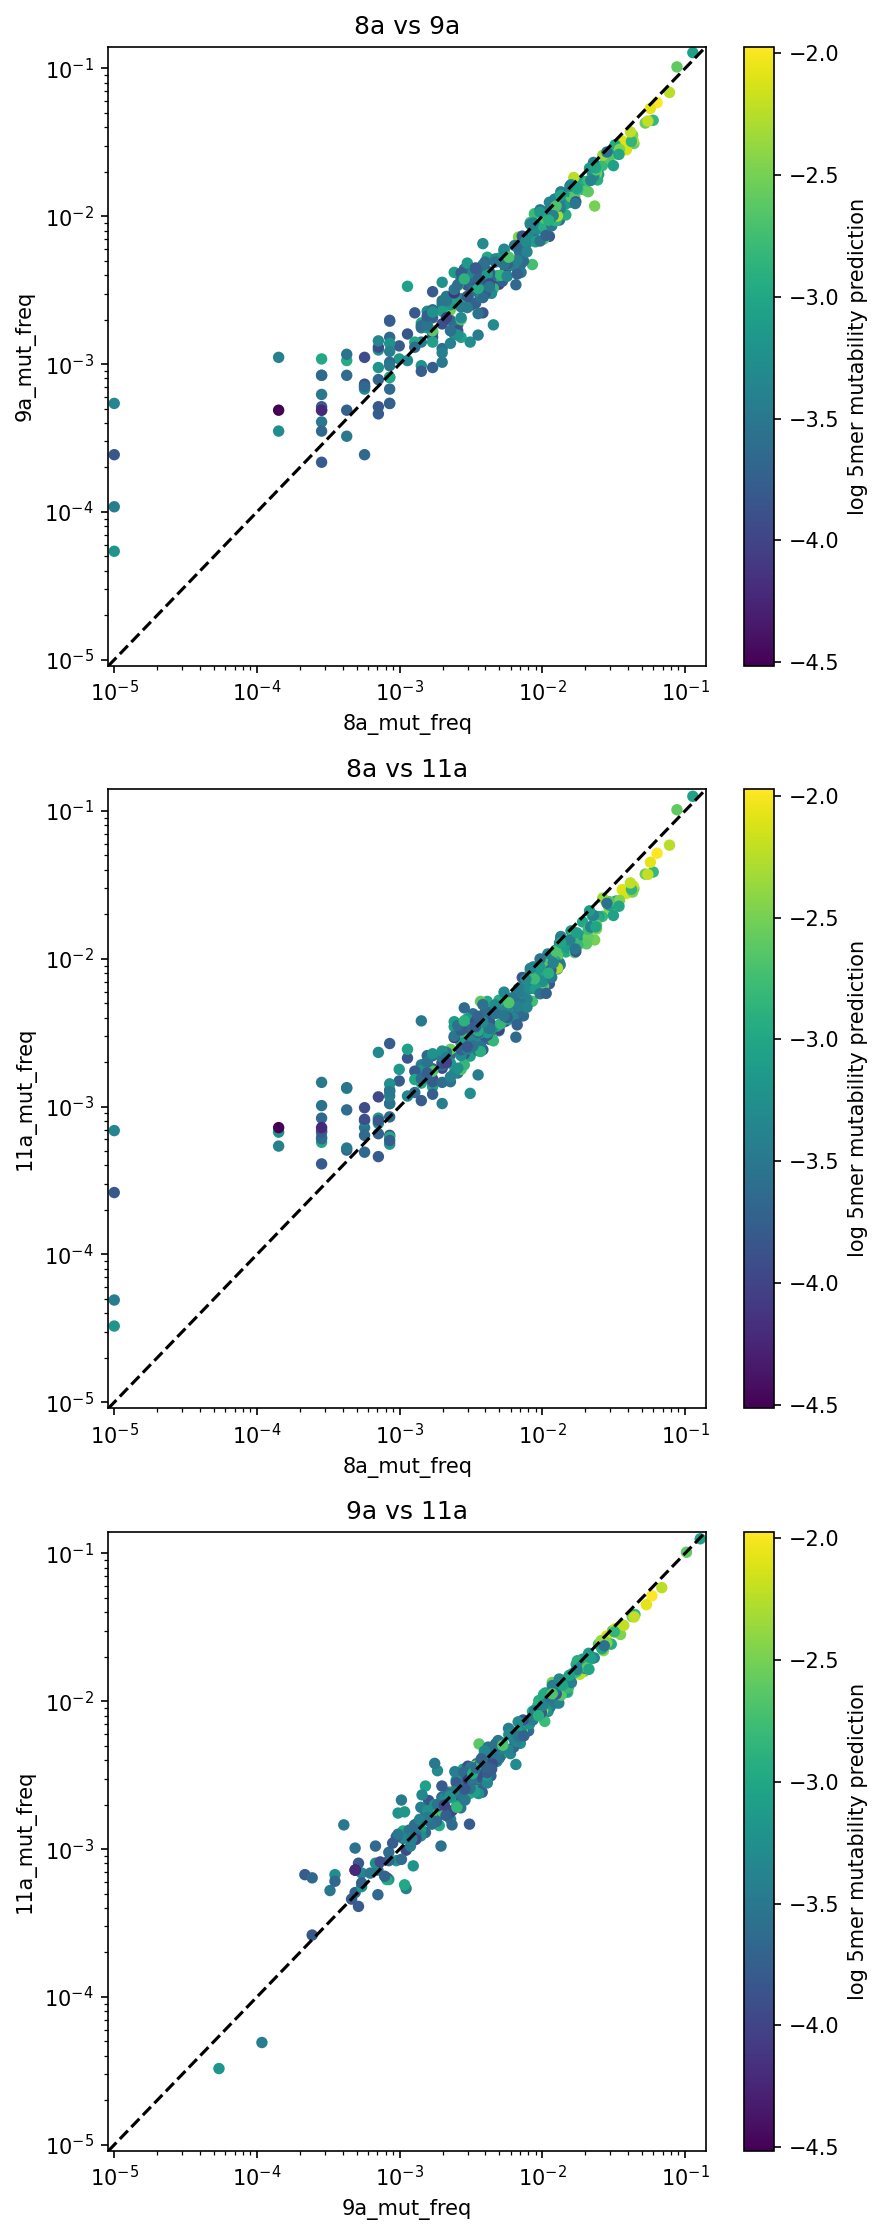

In [5]:
cbar_title = 'log 5mer mutability prediction'
df[cbar_title] = np.log10(df['Mutability'])

#df.plot.scatter(x='8a-mut-freq', y='9a-mut-freq', c='log Mutability', colormap='viridis', loglog=True)

min_limit = min(df['8a_mut_freq'].min(), df['9a_mut_freq'].min(), df['11a_mut_freq'].min())/1.1
max_limit = max(df['8a_mut_freq'].max(), df['9a_mut_freq'].max(), df['11a_mut_freq'].max())*1.1

def set_limits_and_styles(ax, title, min_limit, max_limit):
    ax.set_title(title)
    ax.set_xlim(min_limit, max_limit)
    ax.set_ylim(min_limit, max_limit)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min_limit, max_limit], [min_limit, max_limit], 'k--')  # Add x=y line


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 15))

# Plot each scatter plot
df.plot.scatter(x='8a_mut_freq', y='9a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[0])
set_limits_and_styles(axs[0], '8a vs 9a', min_limit, max_limit)

df.plot.scatter(x='8a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[1])
set_limits_and_styles(axs[1], '8a vs 11a', min_limit, max_limit)

df.plot.scatter(x='9a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[2])
set_limits_and_styles(axs[2], '9a vs 11a', min_limit, max_limit)

plt.tight_layout()
plt.show()


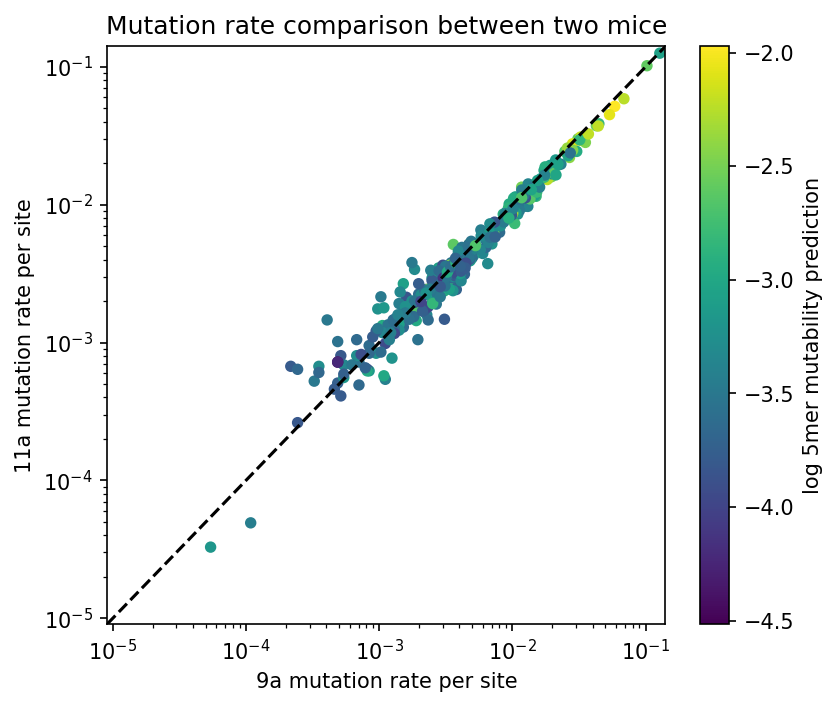

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

df.plot.scatter(x='9a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=ax)
set_limits_and_styles(ax, '9a vs 11a', min_limit, max_limit)
plt.title("Mutation rate comparison between two mice")
plt.xlabel("9a mutation rate per site")
plt.ylabel("11a mutation rate per site")
fig.savefig('passenger_9a_vs_11a.svg', format='svg', dpi=300)

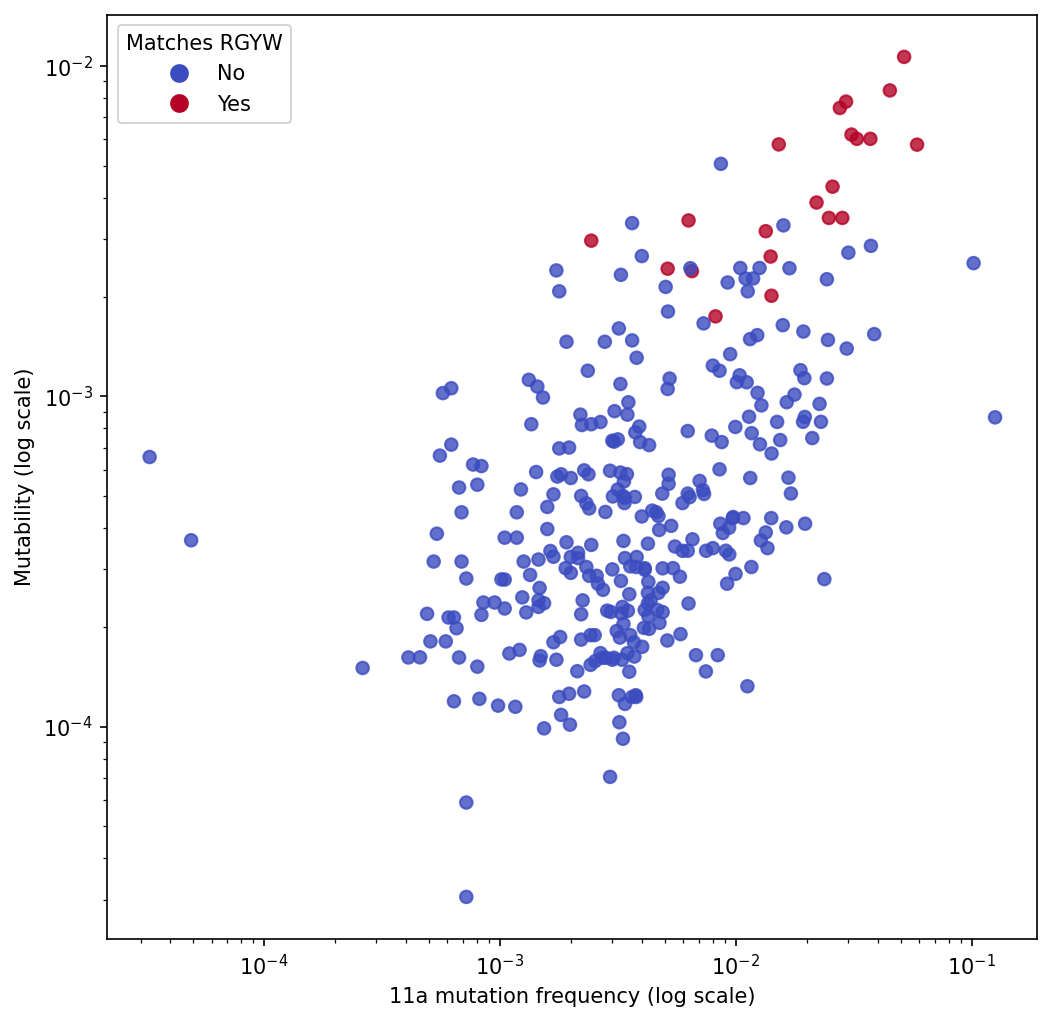

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it has columns 'Fivemer', '8a-mut-freq', 'Mutability'

# Apply the matches_RGYW function to the 'Fivemer' column
df['matches_RGYW'] = df['Fivemer'].apply(matches_RGYW)

# Create a scatter plot
plt.figure(figsize=(8, 8))  # Square aspect ratio
scatter = plt.scatter(df['11a_mut_freq'], df['Mutability'], c=df['matches_RGYW'], cmap='coolwarm', alpha=0.8)

# Set x and y axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('11a mutation frequency (log scale)')
plt.ylabel('Mutability (log scale)')

# Create a custom legend
legend_labels = ['No', 'Yes']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i], 
                      markersize=10, markerfacecolor=scatter.cmap(scatter.norm(i))) for i in range(2)]
plt.legend(handles, legend_labels, title="Matches RGYW")

plt.show()


In [8]:
pseudocount = 0.5

by_base_dfs = {}
for prefix in prefixes:
    by_base_dfs[prefix] = pd.read_csv(f'{prefix}_counts_by_base.csv', index_col=0)
    by_base_dfs[prefix] = by_base_dfs[prefix].replace(-1, float("nan"))
    assert by_base_dfs[prefix].min().min() >= 0

# total these dfs
by_base_df = sum(df for df in by_base_dfs.values())

# assert that there are no other negative values
by_base_df += pseudocount
# replace all nans by 0
by_base_df = by_base_df.fillna(0)
by_base_df = by_base_df.div(by_base_df.sum(axis=1), axis=0)
by_base_df.to_csv(output_prefix+"_substitution.csv")
by_base_df

,A,C,G,T
0,0.411765,0.294118,0.000000,0.294118
1,0.000000,0.060465,0.265116,0.674419
2,0.529412,0.000000,0.281046,0.189542
3,0.000000,0.063209,0.257699,0.679092
4,0.306811,0.494268,0.198921,0.000000
...,...,...,...,...
317,0.000000,0.134990,0.578688,0.286322
318,0.000000,0.223619,0.592127,0.184254
319,0.000000,0.013225,0.078101,0.908674
320,0.000000,0.090909,0.636364,0.272727


## Combining information across the three experiments

Let $i$ index the sites, and $j$ represent the experiment.
We will use the notation:

* $n_{ij}$: the number of mutations observed at site $i$ in experiment $j$
* $r_i$: the rate of mutation at site $i$
* $\lambda_j$: the Poisson offset for experiment $j$ representing the length of the period of affinity maturation
* $s_j$: the sequencing depth of experiment $j$

We will model

$$
n_{ij} \sim \operatorname{Pois}(r_i \lambda_j s_j)
$$

The log likelihood for this model across all sites and experiments will be 

$$
C + \sum_{i,j} \left[n_{ij} \log(r_i \lambda_j s_j) - r_i \lambda_j s_j \right]
$$

In [9]:
by_site_df = pd.DataFrame({name: df.sum(axis=1, skipna=True) for name, df in by_base_dfs.items()})
by_site_df

,8a,9a,11a
0,0.0,4.0,3.0
1,2.0,15.0,89.0
2,1.0,41.0,33.0
3,32.0,68.0,207.0
4,62.0,289.0,389.0
...,...,...,...
317,222.0,812.0,1198.0
318,78.0,347.0,488.0
319,800.0,4723.0,7670.0
320,0.0,2.0,2.0


In [10]:
read_counts = jnp.array([7043, 36903, 61047])
site_count = by_site_df.shape[0]
experiment_count = by_site_df.shape[1]

def neg_log_likelihood(params, n_ij, s_j):
    log_r_i, log_lambda_j = params[:site_count], params[site_count:]
    lambda_j = jnp.exp(log_lambda_j)
    r_i = jnp.exp(log_r_i)
    expected = r_i[:, None] * lambda_j[None, :] * s_j[None, :]
    ll = n_ij * jnp.log(expected) - expected
    return -jnp.sum(ll)

n_ij = jnp.array(by_site_df)
initial_params = jnp.log(jnp.ones(site_count + experiment_count))

neg_log_likelihood(initial_params, n_ij, read_counts)

Array(30961936., dtype=float32)

In [11]:
# Set up the optimizer
optimizer = ScipyMinimize(fun=neg_log_likelihood, method='BFGS')

# Optimize the parameters
result = optimizer.run(initial_params, n_ij=n_ij, s_j=read_counts)

# Extract the optimized parameters
opt_params = result.params
r_i_opt = jnp.exp(opt_params[:site_count])
lambda_j_opt = jnp.exp(opt_params[site_count:])

print("Optimized lambda_j:", lambda_j_opt)
neg_log_likelihood(opt_params, n_ij, read_counts)

Optimized lambda_j: [0.0052054  0.00463508 0.00425771]


Array(-1462012.8, dtype=float32)

We see good concordance with just the normalized frequency using the 11a data:

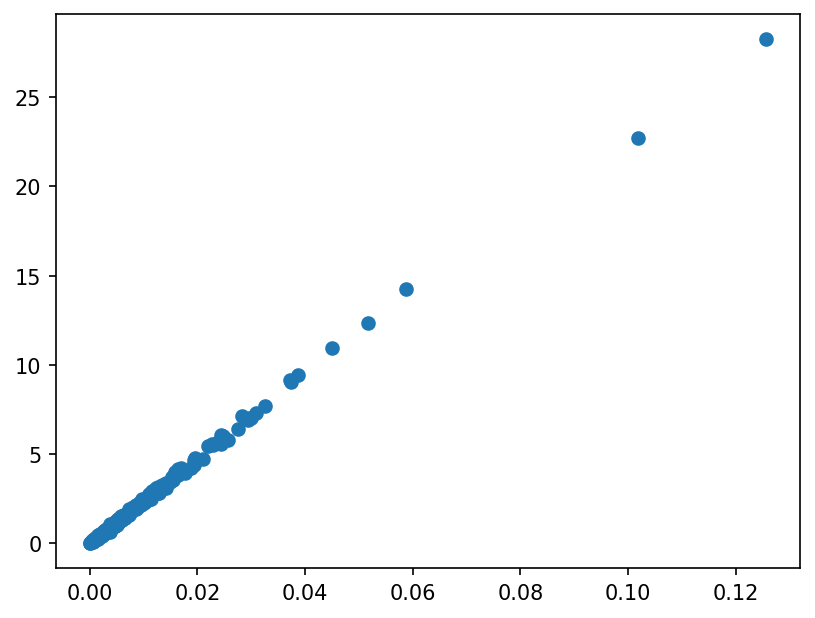

In [12]:
plt.scatter(df["11a_mut_freq"], r_i_opt)